<a href="https://colab.research.google.com/github/raynardj/python4ml/blob/master/experiments/rl/atari_pooyan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pooyan with DQN

In [0]:
%matplotlib inline

Install modules

In [2]:
!apt-get install -y xvfb

!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

!pip install gym
!pip install gym[atari]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.2 [783 kB]
Fetched 783 kB in 7s (119 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.2_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.2) ...
Setting up xvfb (2:1.19.6-1ubuntu4.2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
  Stored in directory: /root/.cache/pip/wheels/d1/8c/16/1c64227974ae29c687e4cc30fd691d5c

Import libraries and modules

In [0]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image


import torch
from torch import nn,optim
from torch.nn import functional as F
from torchvision import transforms as T

## Set up environment

In [4]:
env = gym.make("Pooyan-v0").unwrapped

# set up matplotlib
is_ipy = 'inline' in matplotlib.get_backend()
if is_ipy:
    from IPython import display
    
plt.ion()

# if GPU is used
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("We are using IPython", is_ipy)
print("We are on device", dev)

We are using IPython True
We are on device cuda


## Replay Memory

In [0]:
Transition = namedtuple("Transition",
                        ("state","action","next_state","reward"))

class Replay_Memory(object):
    def __init__(self,capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self,*args):
        """
        args: in order: state, action, next_state, reward
        """
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position+1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
        
    def __len__(self):
        return len(self.memory)

## DQN Algorithm

In [0]:
class DQN(nn.Module):
    def __init__(self, action_space = 2, flatten = 512):
        super(DQN,self).__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=5,stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32, kernel_size=5,stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,32, kernel_size=5,stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32,64, kernel_size=5,stride=2)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64,64, kernel_size=5,stride=2)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.head = nn.Sequential(*[
            nn.Linear(flatten, flatten, ), 
            nn.ReLU(),
            nn.Linear(flatten, action_space),
                                   ])
        
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(x.size(0),-1)
        x = self.head(x)
        return x

In [0]:
# Testing Forward Pass Shape
# dqn = DQN()
# dqn(torch.rand(1,3,250,160)).size()

#### Image Get & Transformation Pipeline

In [0]:
resize = T.Compose([
    T.ToPILImage(),
    T.Resize((250,160),interpolation=Image.CUBIC),
    T.ToTensor()
                     ])

In [0]:
def get_screen():
    """
    screen,screen_arr = get_screen()
    plt.imshow(screen_arr)
    return: Image Tensor(BCHW), numpy.array(HWC)
    """
    raw_arr = env.render(mode = "rgb_array")
    arr = raw_arr.transpose(2,0,1) # 3,250,160
    # strip off unnecessary
    screen = torch.from_numpy(raw_arr)
    return screen.unsqueeze(0).to(dev), raw_arr

In [0]:
screen,screen_arr = get_screen()

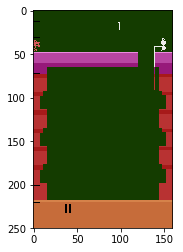

In [11]:
plt.imshow(screen_arr)

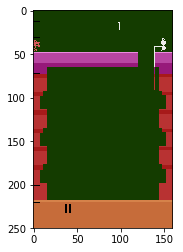

In [0]:
plt.imshow(env.reset())

### Training

In [0]:
# Configs

BS = 128
GAMMA = .999

EPS_START = .9
EPS_END = .05
DECAY = 2000
TARGET_UPDATE = 10

ACTION_SPACE = env.action_space.n

# Initialize

policy_net = DQN().to(dev)
target_net = DQN().to(dev)

def sync(p,t):
    """
    target_net = sync(policy_net,target_net)
    """
    t.load_state_dict(p.state_dict())
    t.eval()
    return t

target_net = sync(policy_net, target_net)

opt = optim.RMSprop(policy_net.parameters())
memory = Replay_Memory(int(1e4))

steps_done = 0

In [0]:
def select_action(state):
    """
    Choose an action from state
    But with some chances, choose randomly
    """
    global steps_done
    sample = random.sample()
    eps_threshold = EPS_END+(EPS_START - EPS_END) * math.exp(-1. * steps_done/DECAY)
    steps_don+=1
    if sample > eps_threshold:
        # choose according to policy
        with torch.no_grad():
            return policy_net(state).max(dim = 1)[1].view(1,1)
    else:
        # choose randomly
        return torch.tensor([[random.randrange(ACTION_SPACE)]], device=dev, dtype = torch.long)

### Training Loop

In [0]:
def optimize():
    """
    optimize step, 
    return: loss value
    """
    if len(memory) < BS:
        # do nothing when didn't play enough game
        return {"loss":0.}
    transitions = memory.sample(BS)
    
    batch = Transition(zip(*transitions))
    
    none_final_mask = torch.tensor(list(map(lambda s: s != None, batch.next_state)),
                                   device=dev, dtype = torch.unit8)
    none_final_next = torch.cat(list(s for s in batch.next_state if s != None))
    
    state_batch = torch.cat(batch.state, dim=0)
    action_batch = torch.cat(batch.action, dim=0)
    reward_batch = troch.cat(batch.reward, dim=0)
    
    # Compute Q(s_t,a)
    # * The model computes Q(s_t)
    # * Use .gather to choose the state value by action taken
    state_action_values = policy_net(state_batch).gather(1,action_batch)
    
    # Compute V(s_{t+1}) for all next states, left part of the loss
    next_state_values = torch.zeros(BS,device=dev)
    next_state_values[none_final_max] = policy_net(non_final_next).max(dim=1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + batch_reward
    
    # Compute Huber Loss, right part of the loss
    loss = F.smooth_l1_loss(state_action_values, 
                            expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    opt.zero_grad()
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1,1)
    
    opt.step()
    
    return {"loss":loss.item()}